In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
def rgb_gray(rgb):
    return np.dot(rgb[...,:3],[0.2989, 0.5870, 0.1140])

In [3]:
(x_train,_), (x_test,_) = cifar10.load_data()

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
imgs_dir = "kayıtlı_image"
save_dir = os.path.join(os.getcwd(),imgs_dir)
print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

C:\Users\Damla\Desktop\yapay_zeka_üçüncübinyıl\Ders Ortamı-YZ_16.01.2023\16.hafta\kayıtlı_image


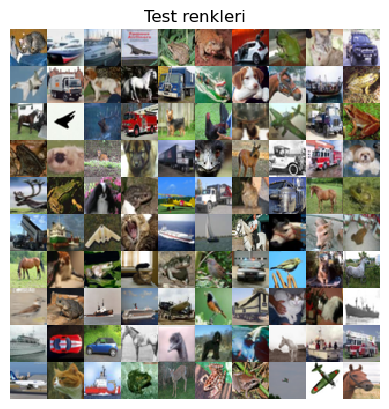

In [6]:
imgs = x_test[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test renkleri')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_renk.png' % imgs_dir)
plt.show()

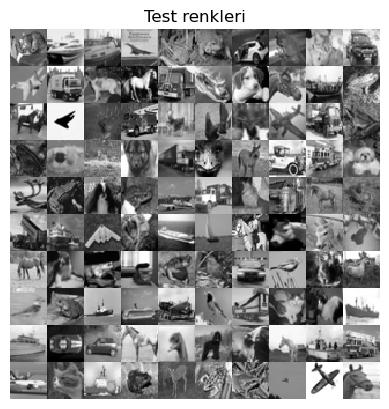

In [7]:
x_train_gray = rgb_gray(x_train)
x_test_gray = rgb_gray(x_test)

imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test renkleri')
plt.imshow(imgs, interpolation='none',cmap='gray')
plt.savefig('%s/test_gri_renk.png' % imgs_dir)
plt.show()

In [8]:
#Normalizasyon
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [9]:
x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,channels)
x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,channels)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0],img_rows,img_cols,1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0],img_rows,img_cols,1)

In [10]:
#Model Network Parameters
input_shape = (img_rows,img_cols,1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64,128,256]


In [11]:
#Model Network Architecture
inputs = Input(shape=input_shape, name='encoder-input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu',padding='same')(x)
    
shape=K.int_shape(x)

x=Flatten()(x)
latent=Dense(latent_dim, name='latent-vector')(x)

encoder=Model(inputs,latent,name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim),name='decoder-input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu',padding='same')(x)

outputs = Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid',padding='same',name='decoder_output')(x)

decoder =Model(latent_inputs,outputs,name='decoder')
decoder.summary()

autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder-input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent-vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1418496 (5.41 MB)
Trainable params: 1418496 (

In [12]:
save_dir = os.path.join(os.getcwd(),'saved_models')
model_name = 'colorization_ae.{epoch:03d}.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir,model_name)

In [13]:
reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,verbose=1,min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1,save_best_only=True)

autoencoder.compile(loss='mse',optimizer='adam')

callbacks =[reducer,checkpoint]

In [ ]:
autoencoder.fit(x_train_gray,x_train,validation_data=(x_test_gray,x_test),epochs=50,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0156
Epoch 1: val_loss improved from inf to 0.01099, saving model to C:\Users\Damla\Desktop\yapay_zeka_üçüncübinyıl\Ders Ortamı-YZ_16.01.2023\16.hafta\saved_models\colorization_ae.001.h5


C:\Users\Damla\anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 331s 205ms/step - loss: 0.0156 - val_loss: 0.0110 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss improved from 0.01099 to 0.00978, saving model to C:\Users\Damla\Desktop\yapay_zeka_üçüncübinyıl\Ders Ortamı-YZ_16.01.2023\16.hafta\saved_models\colorization_ae.002.h5
1563/1563 [==============================] - 312s 200ms/step - loss: 0.0102 - val_loss: 0.0098 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0093
Epoch 3: val_loss improved from 0.00978 to 0.00894, saving model to C:\Users\Damla\Desktop\yapay_zeka_üçüncübinyıl\Ders Ortamı-YZ_16.01.2023\16.hafta\saved_models\colorization_ae.003.h5
1563/1563 [==============================] - 318s 204ms/step - loss: 0.0093 - val_loss: 0.0089 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0087
Epoch 4: val_loss improved from 0.00894 to 0.00852, saving model to

In [ ]:
x_decoded = autoencoder.predict(x_test_gray)

imgs = x_decoded[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Renklendirilmiş resimler')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_gri_renk.png' % imgs_dir)
plt.show()